<a href="https://colab.research.google.com/github/emincingoz/Machine_Learning_Collection/blob/scratch/Image_Classification_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[source](https://keras.io/examples/vision/image_classification_from_scratch/)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!ls MyDrive/CNN

fashion_MNIST_CNN.ipynb			 model.png
gender_classification.ipynb		 saved_epochs
Image_Classification_from_Scratch.ipynb


In [ ]:
#!curl is an utility for transferring data from ...
!curl https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip -L -o MyDrive/CNN/catsanddogs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  56.6M      0  0:00:13  0:00:13 --:--:-- 61.3M


In [ ]:
import os

os.chdir('/gdrive/MyDrive/CNN/')

!ls

catsanddogs.zip		 gender_classification.ipynb		  model.png
fashion_MNIST_CNN.ipynb  Image_Classification_from_Scratch.ipynb  saved_epochs


In [ ]:
!unzip -q catsanddogs.zip
!ls

 catsanddogs.zip			  'MSR-LA - 3467.docx'
 fashion_MNIST_CNN.ipynb		   PetImages
 gender_classification.ipynb		  'readme[1].txt'
 Image_Classification_from_Scratch.ipynb   saved_epochs
 model.png


In [ ]:
!ls PetImages

Cat  Dog


## Filter Out Corrupted Images

[Wikipedia](https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format#File_format_structure) explains that JPG files contain the string "JFIF" at the beginning of the file, encoded as bytes

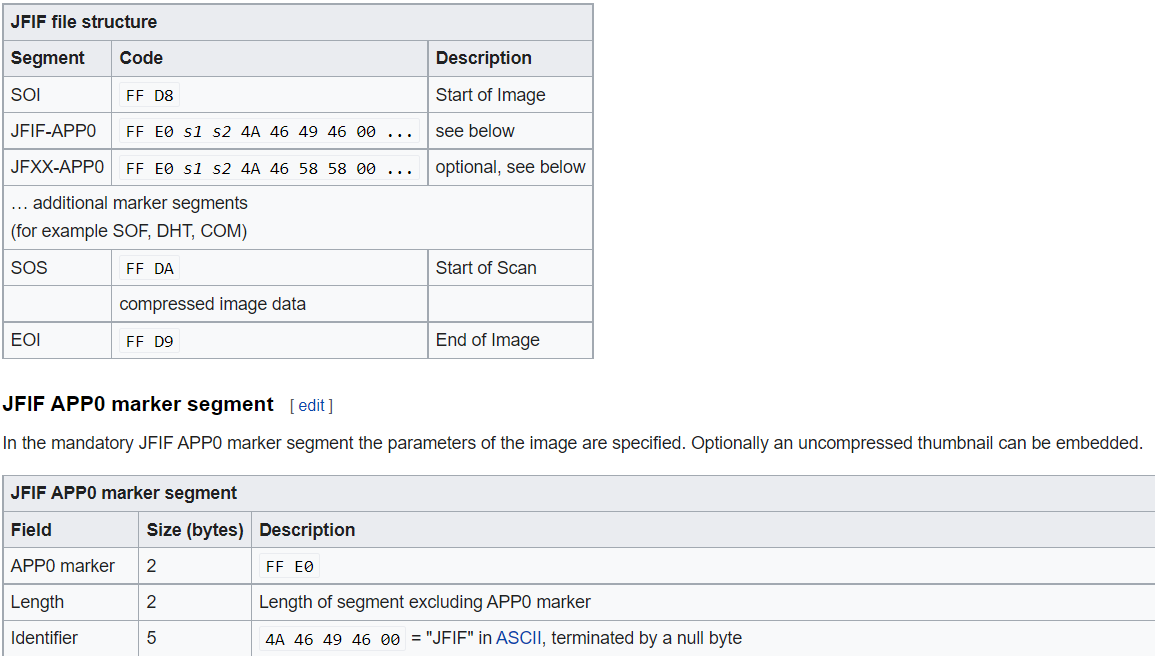

In [ ]:
import os

num_skipped = 0
for folder_name in('Cat', 'Dog'):
  # add folder_name to PetImages
  folder_path = os.path.join('PetImages', folder_name)

  # It keeps the files in folder_path as a list
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)

    try:
      # 'rb': Opens the file in binary format for reading
      fobj = open(fpath, 'rb')
      # tf.compat.as_bytes("JFIF") converts the string "JFIF" to bytes.
      # You could also just use b'JFIF'
      # fobj.peek(10) theoretically returns the first 10 bytes of the file
      is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1

      # delete corrupted images
      os.remove(fpath)

print('Deleted %d images' % num_skipped)

Deleted 1561 images


## Generate a Dataset

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_size = (180, 180)
batch_size = 32

train_ds = image_dataset_from_directory('PetImages', 
                                        validation_split = 0.2, 
                                        subset = 'training', 
                                        seed = 1337, 
                                        image_size = image_size, 
                                        batch_size = batch_size) 

val_ds = image_dataset_from_directory('PetImages', 
                                        validation_split = 0.2, 
                                        subset = 'validation', 
                                        seed = 1337, 
                                        image_size = image_size, 
                                        batch_size = batch_size) 

Found 23439 files belonging to 2 classes.
Using 18752 files for training.
Found 23439 files belonging to 2 classes.
Using 4687 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## Visualize the Data

* label 1 is 'dog'
* label 0 is 'cat'


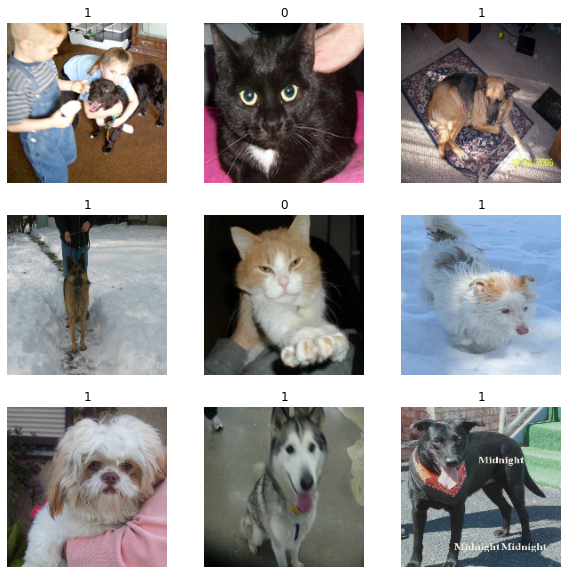

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

## Using Image Data Augmentation

When you don't have a large image dataset, it's a good idea to artificially introduce sample diversity by applying random yet realistic transformations

In [ ]:
data_augmentation = keras.Sequential(
    [
          layers.RandomFlip('horizontal'),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.5),
          layers.RandomContrast(0.2),
          layers.RandomTranslation(0.2, 0.2),
    ]
)

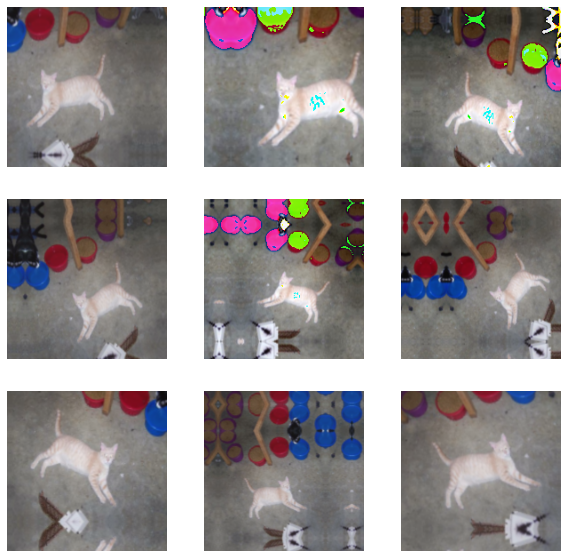

In [ ]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

## Standardize the Data

### Option 1

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this is the better option.

In [ ]:
input_shape=image_size + (3,)
input_shape

(180, 180, 3)

In [ ]:
inputs = keras.Input(shape = input_shape)

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

### Option 2

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the first option.

In [ ]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y))

## Configure the Dataset for Performance

GPU'lar ve TPU'lar, tek bir eğitim adımını yürütmek için gereken süreyi önemli ölçüde azaltabilir. En yüksek performansı elde etmek, mevcut adım bitmeden bir sonraki adım için veri sağlayan verimli bir girdi hattı gerektirir. [See](https://www.tensorflow.org/guide/data_performance).
Prefetch() methodu buradaki performan iyileştirmesi için kullanılır.
> Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements. [See](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset#prefetch)

> buffer_size: 	A tf.int64 scalar tf.Tensor, representing the maximum number of elements that will be buffered when prefetching. If the value tf.data.AUTOTUNE is used, then the buffer size is dynamically tuned.

Normal Çalışma Zamanı:
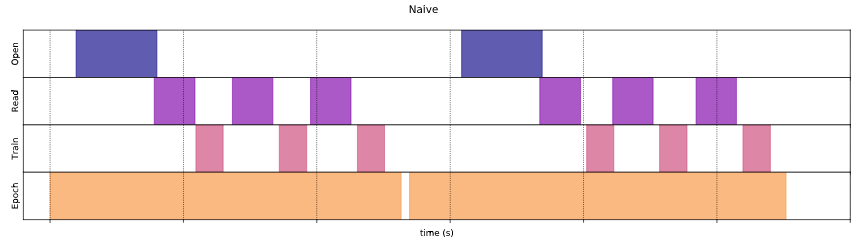

Prefetched/Ön Yüklemeli Çalışma Zamanı:
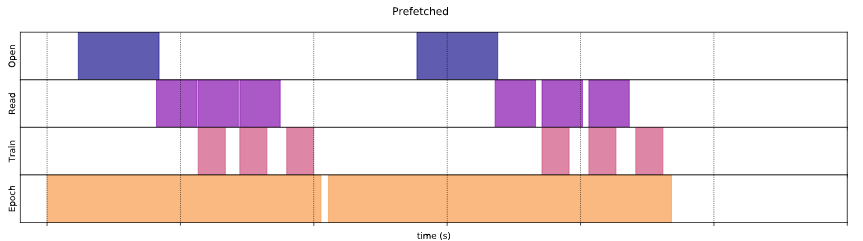

In [ ]:
train_ds = train_ds.prefetch(buffer_size = 32)
val_ds = val_ds.prefetch(buffer_size = 32)

## Build a Model

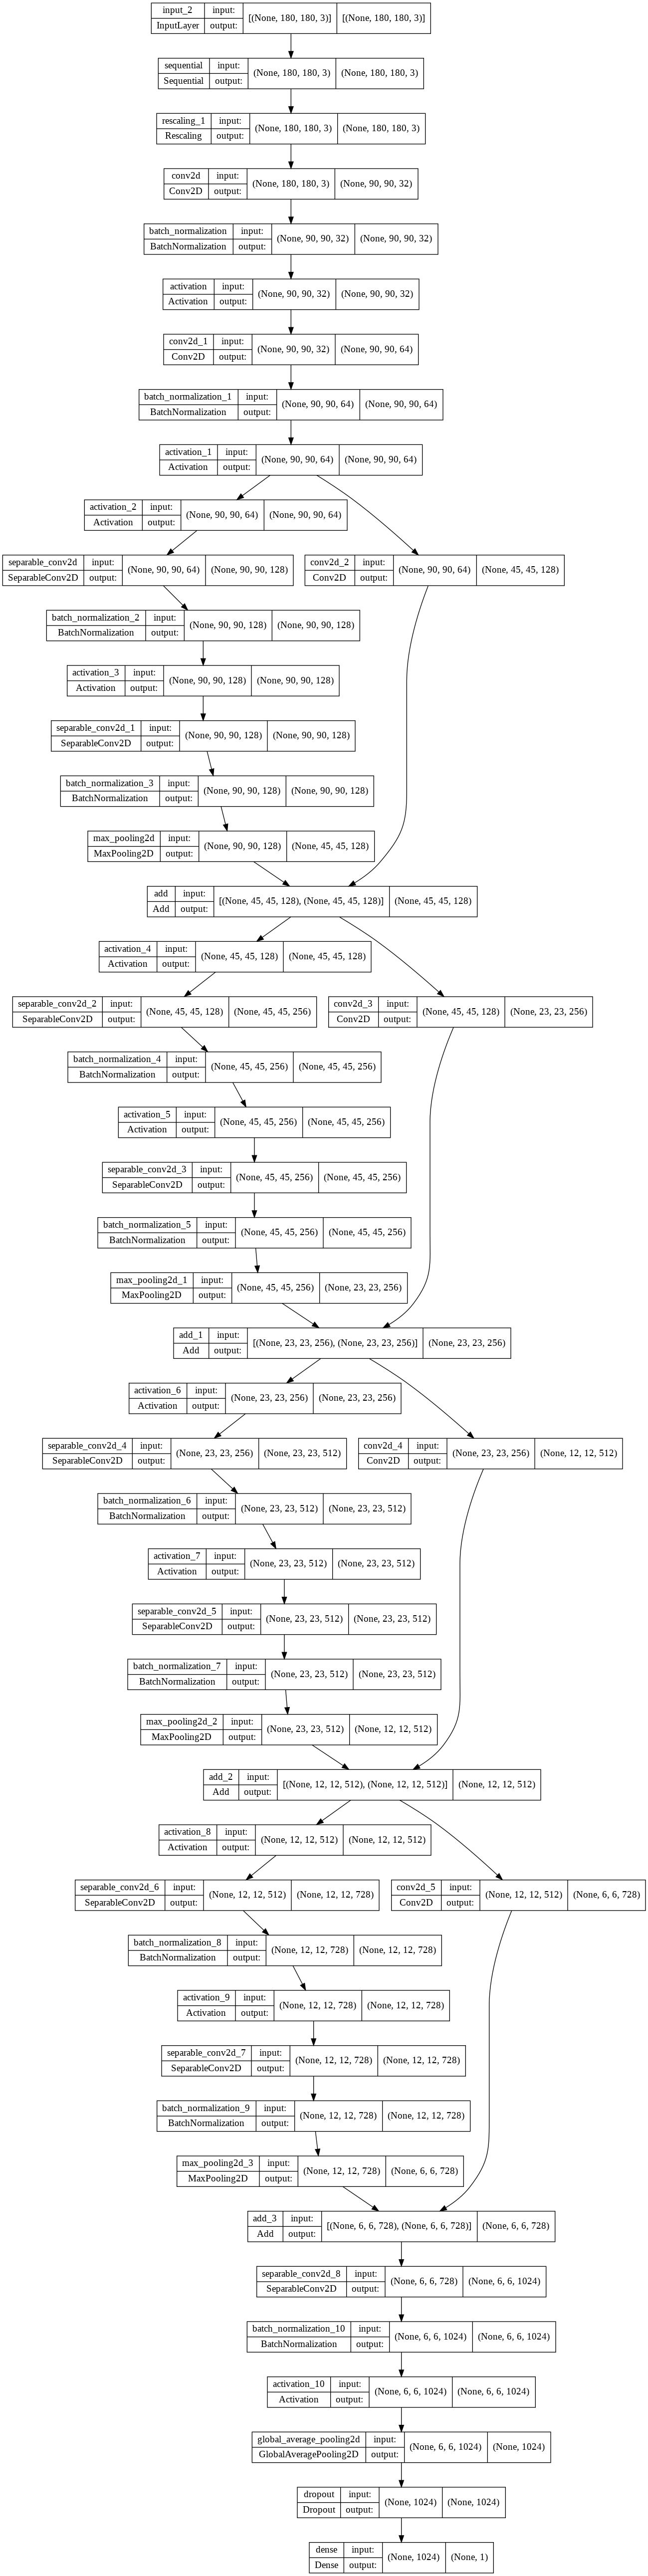

In [ ]:
# Small version of Xception Network

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)

  # Data Augmentation block
  x = data_augmentation(inputs)

  # Entry Block
  x = layers.Rescaling(1.0/255)(x)
  x = layers.Conv2D(32, 3, strides = 2, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  # set aside residual
  previous_block_activation = x

  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides = 2, padding = 'same')(x)

    # Project Residual
    residual = layers.Conv2D(size, 1, strides = 2, padding = 'same')(previous_block_activation)

    # Add back residual
    x = layers.add([x, residual])
    # Set aside next residual
    previous_block_activation = x

  x = layers.SeparableConv2D(1024, 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation = activation)(x)

  return keras.Model(inputs, outputs)


model = make_model(input_shape = input_shape, num_classes = 2)

keras.utils.plot_model(model, show_shapes = True)

## Train the Model

[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/)

[ModelCheckpoint - Save model after every epoch](https://datascience.stackexchange.com/questions/28210/keras-callback-example-for-saving-a-model-after-every-epoch)

In [ ]:
epochs = 50

# ModelCheckpoint is callback to save the Keras model or model weights at some frequency
'''
ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or 
weights (in a checkpoint file) at some interval, so the model or weights can be loaded later 
to continue the training from the state saved.
'''
callbacks = [
             keras.callbacks.ModelCheckpoint('saved_epochs/save_at_{epoch}.h5', 
                                             verbose=0, 
                                             save_best_only=False, 
                                             save_weights_only=False, 
                                             mode='auto')]

model.compile(optimizer = keras.optimizers.Adam(1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# load saved model 
model.load_weights('saved_epochs/save_at_13.h5')

In [ ]:
model.get_weights()

In [ ]:
loss,acc = model.evaluate(train_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

586/586 - 1063s - loss: 0.1913 - accuracy: 0.9173 - 1063s/epoch - 2s/step
Restored model, accuracy: 91.73%


In [ ]:
model.fit(train_ds, epochs = epochs - 13, callbacks = callbacks, validation_data = val_ds)

## Run inference on new data

In [27]:
img = keras.preprocessing.image.load_img('PetImages/Cat/6779.jpg', target_size = image_size)

img_array = keras.preprocessing.image.img_to_array(img)
# Create batch axis
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)
score = prediction[0]
print('This image is %.2f percent cat and %.2f percent dog' % (100 * (1 - score), 100 * score))

This image is 91.61 percent cat and 8.39 percent dog
